In [1]:
import polars as pl
from statsmodels.api import OLS
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd

In [2]:
df = pl.read_parquet('..\\data\\candle_data.parquet').sort(by='tradetime')
close_std = df['close'].std()

In [3]:
df.head()

time,low,high,open,close,volume,tradetime,product_id
f64,f64,f64,f64,f64,f64,datetime[μs],str
1.7126e9,71461.93,71533.53,71511.95,71483.43,16.194006,2024-04-09 02:50:00,"""BTC-USD"""
1.7126e9,71461.18,71534.54,71483.58,71477.15,20.88487,2024-04-09 02:55:00,"""BTC-USD"""
1.7126e9,71365.91,71497.06,71482.64,71420.61,42.464219,2024-04-09 03:00:00,"""BTC-USD"""
1.7126e9,71396.54,71440.71,71416.92,71425.48,18.145278,2024-04-09 03:05:00,"""BTC-USD"""
1.7126e9,71410.84,71605.86,71425.08,71589.98,14.34884,2024-04-09 03:10:00,"""BTC-USD"""


In [4]:
def linear_regression(df, x_col, y_col):
  """
  Performs linear regression on a Polars DataFrame.

  Args:
      df: The Polars DataFrame containing data.
      x_col: The column name for the independent variable (e.g., lagged price).
      y_col: The column name for the dependent variable (current close price).

  Returns:
      A statsmodels.api.OLS fitted model object.
  """
  model = OLS.from_formula(f"{y_col} ~ {x_col}", data=df)
  return model.fit()

In [5]:
lag = 40
model = linear_regression(df, f"close.shift({lag})", "close")
num_std = 1

In [6]:
# Extract slope and intercept from the fitted model
slope = model.params[f'close.shift({lag})']
intercept = model.params["Intercept"]

# Calculate standard deviation of residuals
std_dev = model.resid.std()

# Add new columns for upper and lower bands
df = df.with_columns(
    upper_band = df["close"].shift(lag) * slope + intercept + (num_std * std_dev))

df = df.with_columns(
    lower_band = df["close"].shift(lag) * slope + intercept - (num_std * std_dev))

df = df.with_columns(
    regline = df['close'].shift(lag) * slope + intercept
)

In [7]:
df.head()

time,low,high,open,close,volume,tradetime,product_id,upper_band,lower_band,regline
f64,f64,f64,f64,f64,f64,datetime[μs],str,f64,f64,f64
1.7126e9,71461.93,71533.53,71511.95,71483.43,16.194006,2024-04-09 02:50:00,"""BTC-USD""",null,null,null
1.7126e9,71461.18,71534.54,71483.58,71477.15,20.88487,2024-04-09 02:55:00,"""BTC-USD""",null,null,null
1.7126e9,71365.91,71497.06,71482.64,71420.61,42.464219,2024-04-09 03:00:00,"""BTC-USD""",null,null,null
1.7126e9,71396.54,71440.71,71416.92,71425.48,18.145278,2024-04-09 03:05:00,"""BTC-USD""",null,null,null
1.7126e9,71410.84,71605.86,71425.08,71589.98,14.34884,2024-04-09 03:10:00,"""BTC-USD""",null,null,null


In [8]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df["tradetime"], y=df["close"], name="Close",  mode='lines'),
    secondary_y=False,
)

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["upper_band"], name=f"Upper Bank", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["lower_band"], name=f"Lower Band", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["regline"], name=f"Regression Line", mode='lines'))

fig.add_trace(
    go.Scatter(
        x=df["tradetime"],
        y=df["lower_band"],
        fill="tonexty",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name="Premium",
        showlegend=False,
    )
)

fig.add_trace(
    go.Scatter(
        x=df["tradetime"],
        y=df["upper_band"],
        fill="tonexty",
        fillcolor="rgba(0,176,246,0.2)",
        line_color="rgba(255,255,255,0)",
        name="Upper Band Fill",
        showlegend=False,
    )
)

# Add figure title
fig.update_layout(title_text="BTC-USD w/ Indicators")

# Set x-axis title
fig.update_xaxes(title_text="Tradetime (5 min. intervals)")

# Set y-axes titles
fig.update_yaxes(title_text="BTC-USD ($)", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

In [9]:
dfs = df.with_columns(signal = pl.lit('hold'))
dfs = dfs.with_columns(prev_close = pl.col('close').shift())

dfs = dfs.with_columns(
        signal = pl.when((pl.col('close') > pl.col('upper_band')) & (pl.col('prev_close') < pl.col('upper_band')))
        .then(pl.lit('sell'))
        .otherwise(pl.col('signal'))
    )

dfs = dfs.with_columns(
        signal = pl.when((pl.col('close') < pl.col('lower_band')) & (pl.col('prev_close') > pl.col('lower_band')))
        .then(pl.lit('buy'))
        .otherwise(pl.col('signal'))
    )



In [10]:
signals_df = dfs.filter(pl.col('signal') != 'hold')
signals_df.head()

time,low,high,open,close,volume,tradetime,product_id,upper_band,lower_band,regline,signal,prev_close
f64,f64,f64,f64,f64,f64,datetime[μs],str,f64,f64,f64,str,f64
1.7126e9,69622.17,70334.31,70322.5,69835.09,372.149083,2024-04-09 08:05:00,"""BTC-USD""",71705.199804,70000.119448,70852.659626,"""buy""",70321.14
1.7127e9,70796.52,70905.31,70835.0,70903.19,49.145816,2024-04-09 11:10:00,"""BTC-USD""",70892.26344,69187.183084,70039.723262,"""sell""",70839.26
1.7127e9,70767.39,70909.01,70773.11,70886.87,23.298845,2024-04-09 11:20:00,"""BTC-USD""",70838.533733,69133.453376,69985.993554,"""sell""",70776.96
1.7127e9,70666.95,70770.64,70674.28,70758.93,38.516438,2024-04-09 11:45:00,"""BTC-USD""",70676.241791,68971.161435,69823.701613,"""sell""",70674.28
1.7127e9,69355.01,69834.23,69819.19,69372.22,254.34982,2024-04-09 14:35:00,"""BTC-USD""",71264.539565,69559.459209,70411.999387,"""buy""",69823.64


In [11]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df["tradetime"], y=df["close"], name="Close",  mode='lines'),
    secondary_y=False,
)

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["upper_band"], name=f"Upper Bank", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["lower_band"], name=f"Lower Band", mode='lines'))

fig.add_trace(go.Scatter(x=df["tradetime"], y=df["regline"], name=f"Regression Line", mode='lines'))


def color_map(val):
    if val == 'buy':
        return 'green'
    elif val == 'sell':
        return 'red'
    else:
        return 'gray'

fig.add_trace(
    go.Scatter(x=signals_df['tradetime'],
                y = signals_df['close'],
                mode="markers", 
                customdata=signals_df['signal'],
                marker=dict(color=[color_map(val) for val in signals_df['signal']]),
                name = 'BUY/SELL Signal'
                )
            )


# Add figure title
fig.update_layout(title_text="BTC-USD w/ Indicators")

# Set x-axis title
fig.update_xaxes(title_text="Tradetime (5 min. intervals)")

# Set y-axes titles
fig.update_yaxes(title_text="BTC-USD ($)", secondary_y=False)
# fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

In [12]:
# Show strategy outcome
initial_amount = 10000.00 # Principal in dollars ($)
balance = initial_amount
n_assets = 0 # start with 0 assets 

In [13]:
dfs.head()

time,low,high,open,close,volume,tradetime,product_id,upper_band,lower_band,regline,signal,prev_close
f64,f64,f64,f64,f64,f64,datetime[μs],str,f64,f64,f64,str,f64
1.7126e9,71461.93,71533.53,71511.95,71483.43,16.194006,2024-04-09 02:50:00,"""BTC-USD""",null,null,null,"""hold""",null
1.7126e9,71461.18,71534.54,71483.58,71477.15,20.88487,2024-04-09 02:55:00,"""BTC-USD""",null,null,null,"""hold""",71483.43
1.7126e9,71365.91,71497.06,71482.64,71420.61,42.464219,2024-04-09 03:00:00,"""BTC-USD""",null,null,null,"""hold""",71477.15
1.7126e9,71396.54,71440.71,71416.92,71425.48,18.145278,2024-04-09 03:05:00,"""BTC-USD""",null,null,null,"""hold""",71420.61
1.7126e9,71410.84,71605.86,71425.08,71589.98,14.34884,2024-04-09 03:10:00,"""BTC-USD""",null,null,null,"""hold""",71425.48


In [14]:
timeline_df = dfs.select(pl.col('tradetime'), pl.col('close'), pl.col('signal')).to_pandas().sort_values(by = 'tradetime')
timeline_df.shape


(4320, 3)

In [15]:
timeline_df

,tradetime,close,signal
0,2024-04-09 02:50:00,71483.43,hold
1,2024-04-09 02:55:00,71477.15,hold
2,2024-04-09 03:00:00,71420.61,hold
3,2024-04-09 03:05:00,71425.48,hold
4,2024-04-09 03:10:00,71589.98,hold
...,...,...,...
4315,2024-04-24 02:25:00,66565.65,hold
4316,2024-04-24 02:30:00,66585.98,hold
4317,2024-04-24 02:35:00,66621.76,hold
4318,2024-04-24 02:40:00,66640.97,hold


In [16]:
# implement trade logic on signals

trade_log = {}
for idx, row in timeline_df.iterrows():
    signal = row['signal']
    close = row['close']
    tradetime = row['tradetime']

    if (signal == 'buy') & (balance > 0):       
        n_assets = balance / close 
        balance -= n_assets * close

        trade_log[tradetime] = ['buy', close, n_assets, balance]

    elif (signal == 'sell') & (n_assets > 0):
        balance = n_assets * close
        n_assets = 0
        trade_log[tradetime] = ['sell', close, n_assets, balance]

    else:
        next 

if signal == 'buy':
    trade_log[tradetime] = ['sell', close, 0, n_assets * close]

In [17]:
trade_log

{Timestamp('2024-04-09 08:05:00'): ['buy', 69835.09, 0.14319448861596656, 0.0],
 Timestamp('2024-04-09 11:10:00'): ['sell', 70903.19, 0, 10152.946033290715],
 Timestamp('2024-04-09 14:35:00'): ['buy', 69372.22, 0.1463546363845746, 0.0],
 Timestamp('2024-04-10 06:15:00'): ['sell', 69281.41, 0, 10139.65556876063],
 Timestamp('2024-04-10 12:35:00'): ['buy', 67590.0, 0.15001709674153915, 0.0],
 Timestamp('2024-04-10 17:55:00'): ['sell', 69359.4, 0, 10405.09581973511],
 Timestamp('2024-04-12 14:35:00'): ['buy', 69447.58, 0.14982661483287266, 0.0],
 Timestamp('2024-04-13 04:35:00'): ['sell', 67513.77, 0, 10115.359613705154],
 Timestamp('2024-04-13 18:05:00'): ['buy', 66526.22, 0.15205071945625578, 0.0],
 Timestamp('2024-04-14 01:20:00'): ['sell', 63775.75, 0, 9697.148671362305],
 Timestamp('2024-04-14 02:15:00'): ['buy', 63470.41, 0.1527821967963072, 0.0],
 Timestamp('2024-04-14 05:40:00'): ['sell', 64437.19, 0, 9844.855443581038],
 Timestamp('2024-04-14 17:15:00'): ['buy', 63590.01, 0.15481

In [18]:
trades = (
    pd.DataFrame.from_dict(
        trade_log, orient="index", columns=["action", "price", "quantity", "balance"]
    )
    .reset_index()
    .rename(columns={"index": "tradetime"})
)

In [19]:
final_balance = trades.tail(1)['balance']

trading_return = (final_balance - initial_amount) / initial_amount * 100

In [20]:
trading_return

25    1.994425
Name: balance, dtype: float64

<Axes: xlabel='tradetime'>

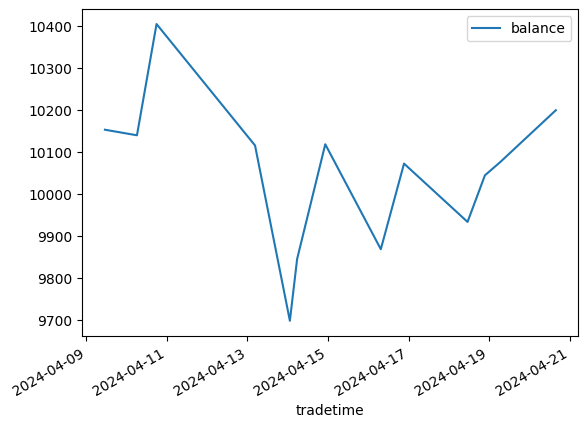

In [24]:
trades[trades['balance'] > 0].plot(x='tradetime',y='balance')